# Gradient-Based Optimization for Generative Models

So far, we've explored how diffusion models and flow matching can generate samples from learned data distributions. But what if we want to guide the generation process toward specific properties or constraints at test time, without retraining the model?

This is where **gradient-based optimization** comes in. The key idea is to modify the generation trajectory by adding gradient-based corrections that steer the samples toward desired characteristics. Instead of just following the learned velocity field, we can add an additional term that pushes the generation in a direction that minimizes (or maximizes) some energy function.

In this notebook, we'll:
- Review flow matching as our base generative model
- Introduce the concept of energy functions and gradient-based steering
- Implement steering mechanisms that can guide generation toward specific properties (like thinness or symmetry)
- See how we can control generation behavior at inference time without modifying the trained model

This technique is powerful because it allows us to add constraints or preferences to generation without needing to retrain, making it a flexible tool for controlled generation.

### Setup and Imports

We'll start by importing the necessary libraries. This notebook builds on the flow matching approach we saw earlier, so we'll reuse many of the same components.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.nn.functional as F

In [ ]:
def compute_flow_match_loss(model, x_1):
    # x_1: Real data batch (Batch, C, H, W)
    b = x_1.shape[0]
    
    # 1. Sample x_0 (Pure Gaussian Noise)
    x_0 = torch.randn_like(x_1)
    
    # 2. Sample random time t (uniform 0 to 1)
    # Make sure to reshape it to (B, 1, 1, 1) for broadcasting!
    t = torch.rand((b,), device=x_1.device)
    t_broad = t.view(-1, 1, 1, 1)
    
    # 3. Compute x_t (Linear Interpolation)
    x_t = (1-t_broad) * x_0 + t_broad * x_1
    
    # 4. Compute Target Velocity (The formula you derived)
    target_v = x_1 - x_0
    
    # 5. Predict with model
    # Note: We need to pass 't' (vector) not 't_broad' to the model usually, 
    # depending on your embedding layer. Let's assume 't' is fine.
    pred_v = model(x_t, t)
    
    # 6. MSE Loss
    return torch.nn.functional.mse_loss(pred_v, target_v)

In [ ]:
@torch.no_grad()
def sample_flow_matching(model, n_samples=16, steps=100, device='mps'):
    # 1. Start with pure noise (Batch, C, H, W)
    # Define x (use IMAGE_SIZE from previous parts)
    x = torch.randn(n_samples, 1, IMAGE_SIZE, IMAGE_SIZE, device=device)
    # Define step size dt
    dt = 1.0 / steps
    
    # 2. Loop from t=0 to t=1
    for i in range(steps):
        # Current time t (scalar or vector)
        t = i * dt
        
        # Create a time tensor for the model (Batch size)
        t_batch = torch.full((n_samples,), t, device=device)
        
        # Get velocity from model
        v = model(x, t_batch)
        
        # Update x using Euler step
        x = x + v*dt
    return x


In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        
    def forward(self, t):
            device = t.device
            emb = torch.zeros(t.shape[0], self.embedding_dim, device=device)
            
            for i in range(self.embedding_dim // 2):
                # We ensure the constant is on the correct device too
                const = torch.tensor(10000.0, device=device) 
                omega_i = torch.exp(-(2*i/self.embedding_dim) * torch.log(const))
                
                emb[:, 2*i] = torch.sin(omega_i * t)
                emb[:, 2*i+1] = torch.cos(omega_i * t)
            
            return emb

### Model Architecture

We'll use the same U-Net architecture from our previous notebooks. The key components are:

1. **Sinusoidal Time Embedding**: Encodes the timestep $t$ into a continuous representation
2. **Block**: A convolutional block that processes spatial features while incorporating time information
3. **Conditional U-Net**: The full encoder-decoder architecture with skip connections


In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        
        # 1. First Convolution: Change channels (e.g. 1 -> 32)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
        # 2. Time Projection: Map time to match 'out_ch'
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        
        # 3. Second Convolution: Refine features
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
    def forward(self, x, t):
        # First Conv
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu(h)
        
        # Add Time Embedding
        # (Batch, Time_Dim) -> (Batch, Out_Ch) -> (Batch, Out_Ch, 1, 1)
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(..., ) + (None, ) * 2] # Broadcast to 4D
        h = h + time_emb
        
        # Second Conv
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu(h)
        
        return h

In [ ]:
class ConditionalUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(32),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        
        self.label_embedding = nn.Embedding(10, 32)
        
        # 1. Down Path
        self.down1 = Block(1, 32, 32)
        self.down2 = Block(32, 64, 32)
        self.down3 = Block(64, 128, 32)
        
        self.pool = nn.MaxPool2d(2)
        
        # 2. Bottleneck
        self.bottleneck = Block(128, 256, 32)
        
        # 3. Up Path
        # We separate the Upsampling (ConvTrans) from the Block (Processing)
        
        # Up 1: 4x4 -> 8x8
        self.up_trans1 = nn.ConvTranspose2d(256, 256, 4, 2, 1) 
        self.up1 = Block(256 + 128, 128, 32) # In: Bottle + Skip(x3)
        
        # Up 2: 8x8 -> 16x16
        self.up_trans2 = nn.ConvTranspose2d(128, 128, 4, 2, 1)
        self.up2 = Block(128 + 64, 64, 32)   # In: Prev + Skip(x2)
        
        # Up 3: 16x16 -> 32x32
        self.up_trans3 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.up3 = Block(64 + 32, 32, 32)    # In: Prev + Skip(x1)
        
        # Final projection
        self.final = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t, label):
        t = self.time_mlp(t)
        label_emb = self.label_embedding(label)
        
        t = t + label_emb
        
        # --- Down Path ---
        x1 = self.down1(x, t)        # (32, 32, 32)
        x_p1 = self.pool(x1)         # (32, 16, 16)
        
        x2 = self.down2(x_p1, t)     # (64, 16, 16)
        x_p2 = self.pool(x2)         # (64, 8, 8)
        
        x3 = self.down3(x_p2, t)     # (128, 8, 8)
        x_p3 = self.pool(x3)         # (128, 4, 4)
        
        # --- Bottleneck ---
        x = self.bottleneck(x_p3, t) # (256, 4, 4)
        
        # --- Up Path ---
        
        # Step 1: Upsample -> Concat -> Process
        x = self.up_trans1(x)                          # (256, 8, 8)
        x = self.up1(torch.cat((x, x3), dim=1), t)     # (128, 8, 8)
        
        # Step 2
        x = self.up_trans2(x)                          # (128, 16, 16)
        x = self.up2(torch.cat((x, x2), dim=1), t)     # (64, 16, 16)
        
        # Step 3
        x = self.up_trans3(x)                          # (64, 32, 32)
        x = self.up3(torch.cat((x, x1), dim=1), t)     # (32, 32, 32)
        
        return self.final(x)

In [ ]:
def compute_flow_match_loss_conditional(model, x_1, labels):
    # x_1: Real data batch (Batch, C, H, W)
    b = x_1.shape[0]
    
    # 1. Sample x_0 (Pure Gaussian Noise)
    x_0 = torch.randn_like(x_1)
    
    # 2. Sample random time t (uniform 0 to 1)
    # Make sure to reshape it to (B, 1, 1, 1) for broadcasting!
    t = torch.rand((b,), device=x_1.device)
    t_broad = t.view(-1, 1, 1, 1)
    
    # 3. Compute x_t (Linear Interpolation)
    x_t = (1-t_broad) * x_0 + t_broad * x_1
    
    # 4. Compute Target Velocity (The formula you derived)
    target_v = x_1 - x_0
    
    # 5. Predict with model
    # Note: We need to pass 't' (vector) not 't_broad' to the model usually, 
    # depending on your embedding layer. Let's assume 't' is fine.
    pred_v = model(x_t, t, labels)
    
    # 6. MSE Loss
    return torch.nn.functional.mse_loss(pred_v, target_v)

In [ ]:
def load_mnist(image_size=32, batch_size=128, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])
    dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    return dataset, dataloader

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

dataset, dataloader = load_mnist(image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, device=device)

### Step 5: Model Setup and Training

Now we'll set up our conditional U-Net model and train it using flow matching.

In [ ]:
model = ConditionalUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 15
# --- Training Loop ---
print("Starting Flow Matching Training...")
model.train()

for epoch in range(EPOCHS):
    epoch_losses = []
    for step, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Calculate Flow Matching Loss
        loss = compute_flow_match_loss_conditional(model, images, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        if step % 100 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")
    
    print(f"Epoch {epoch} Avg Loss: {sum(epoch_losses)/len(epoch_losses):.4f}")

### Standard Conditional Generation

Once trained, we can generate samples by integrating the learned velocity field. The conditional sampling function takes labels and generates the corresponding digits:

In [ ]:
@torch.no_grad()
def sample_flow_matching_conditional(model, labels, steps=100, device='mps'):
    model.eval()
    n_samples = len(labels)
    # 1. Start with pure noise (Batch, C, H, W)
    # Define x (use IMAGE_SIZE from previous parts)
    x = torch.randn(n_samples, 1, IMAGE_SIZE, IMAGE_SIZE, device=device)
    # Define step size dt
    dt = 1.0 / steps
    
    # 2. Loop from t=0 to t=1
    for i in range(steps):
        # Current time t (scalar or vector)
        t = i * dt
        
        # Create a time tensor for the model (Batch size)
        t_batch = torch.full((n_samples,), t, device=device)
        
        # Get velocity from model
        v = model(x, t_batch, labels)
        
        # Update x using Euler step
        x = x + v*dt
    return x


In [ ]:
def plot_images(sampled_images, n_steps):
    # plot sampled images
    plt.figure(figsize=(10, 4))
    grid = vutils.make_grid(sampled_images.cpu(), nrow=10, normalize=True, scale_each=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f'Sampled MNIST Digits via Flow Matching, {n_steps} gen steps')
    plt.axis('off')
    plt.show()

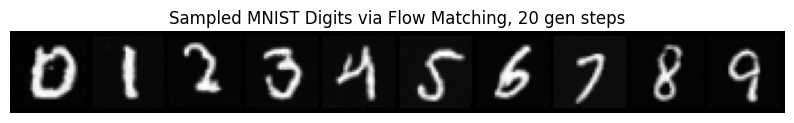

In [ ]:
labels = torch.arange(0, 10).to(device)  # 20 samples (2 of each digit)
n_steps = 20

sampled_images = sample_flow_matching_conditional(model, labels, steps=n_steps, device=device)
plot_images(sampled_images, n_steps)

### Gradient-Based Steering

Now we introduce the core concept: **gradient-based optimization**. The idea is to modify the generation trajectory by adding a term that steers the samples toward (or away from) certain properties.

An **energy function** $E(x)$ measures some property of the sample $x$. We can then use its gradient $\nabla_x E(x)$ to guide the generation. to make digits thicker, we want to maximize this energy, while for thinner digits we will aim at minimizing it.

The modified update step becomes:
$$x_{t+dt} = x_t + v_\theta(x_t, t) \cdot dt + \gamma \cdot \nabla_x E(x_t)$$

where $\gamma$ is a steering strength parameter that controls how much we want to influence the generation.

Let's start with a simple energy function that measures the average pixel intensity. By maximizing this, we can make digits appear thicker (higher values for brighter pixels):

In [ ]:
def energy_fn(x):
    with torch.enable_grad():
        x = x.detach().requires_grad_(True)
        energy = torch.mean(x)
        #backpropagate
        energy.backward()
        
        return x.grad

In [ ]:
@torch.no_grad()
def sample_steered_flow_matching_conditional(model, labels, gamma,steps=100, device='mps'):
    model.eval()
    n_samples = len(labels)
    # 1. Start with pure noise (Batch, C, H, W)
    x = torch.randn(n_samples, 1, IMAGE_SIZE, IMAGE_SIZE, device=device)
    # Define step size dt
    dt = 1.0 / steps
    
    # 2. Loop from t=0 to t=1
    for i in range(steps):
        # Current time t (scalar or vector)
        t = i * dt
        
        # Create a time tensor for the model (Batch size)
        t_batch = torch.full((n_samples,), t, device=device)
        
        # Get velocity from model
        v = model(x, t_batch, labels)
        
        # Update x using Euler step and steering term
        x = x + v*dt - gamma * energy_fn(x) 
    return x


In [ ]:
# 1. Setup Labels
labels = torch.arange(10).to(device)

# 2. Run Normal (Control Group)
print("Generating Normal...")
normal_images = sample_steered_flow_matching_conditional(model, labels, gamma=0.0, steps=20)

# 3. Run Steered (Experimental Group)
# Try gamma = 100.0 to force the effect!
print("Generating Thicker...")
thin_images = sample_steered_flow_matching_conditional(model, labels, gamma=100.0, steps=20) 

# 4. Plot Comparison
fig, axes = plt.subplots(2, 10, figsize=(12, 3))

# Plot Normal
for i in range(10):
    img = (normal_images[i, 0].cpu() + 1) / 2
    axes[0, i].imshow(img.clamp(0, 1), cmap='gray')
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_title("Normal")

# Plot Thinner
for i in range(10):
    img = (thin_images[i, 0].cpu() + 1) / 2
    axes[1, i].imshow(img.clamp(0, 1), cmap='gray')
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title("Steered (Thick)")

plt.suptitle("Steering for Thickness")
plt.show()

### Steering for Symmetry

We can define more sophisticated energy functions to achieve different effects. For example, we can encourage symmetry by measuring the difference between an image and its horizontal flip:


In [ ]:
def symmetry_energy_fn(x):
    with torch.enable_grad():
        x = x.detach().requires_grad_(True)
        x_flipped = torch.flip(x, dims=(3,))
        energy = torch.mean((x - x_flipped) ** 2)
        #backpropagate
        energy.backward()
        return x.grad

We update the steered sampling function to use the symmetry energy. Note that we subtract the gradient (with a minus sign) because we want to minimize the symmetry energy:


In [ ]:
@torch.no_grad()
def sample_steered_flow_matching_conditional(model, labels, gamma,steps=100, device='mps'):
    model.eval()
    n_samples = len(labels)
    # 1. Start with pure noise (Batch, C, H, W)
    # Define x (use IMAGE_SIZE from previous parts)
    x = torch.randn(n_samples, 1, IMAGE_SIZE, IMAGE_SIZE, device=device)
    # Define step size dt
    dt = 1.0 / steps
    
    # 2. Loop from t=0 to t=1
    for i in range(steps):
        # Current time t (scalar or vector)
        t = i * dt
        
        # Create a time tensor for the model (Batch size)
        t_batch = torch.full((n_samples,), t, device=device)
        
        # Get velocity from model
        v = model(x, t_batch, labels)
        
        # Update x using Euler step
        x = x + v*dt - gamma * symmetry_energy_fn(x) 
    return x


Let's test the symmetry steering on digits that naturally have some symmetry (0, 1, and 8). We'll compare normal generation with steered generation to see how the symmetry constraint affects the output:


Generating Normal...
Generating Thinner...


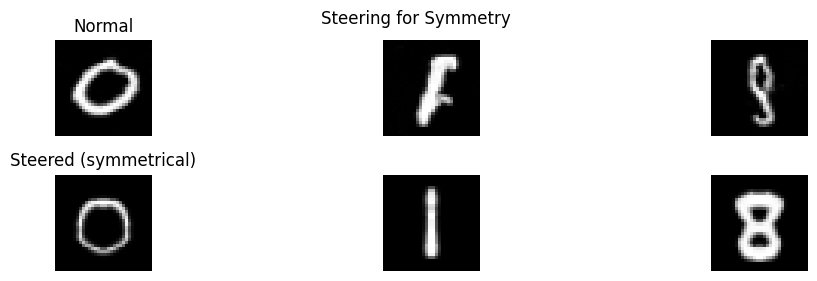

In [ ]:
# 1. Setup Labels
labels = torch.tensor([0,1,8]).to(device)

# 2. Run Normal (Control Group)
print("Generating Normal...")
normal_images = sample_steered_flow_matching_conditional(model, labels, gamma=0.0, steps=80)

# 3. Run Steered (Experimental Group)
# Try gamma = 100.0 to force the effect!
print("Generating Thinner...")
thin_images = sample_steered_flow_matching_conditional(model, labels, gamma=100.0, steps=80) 

# 4. Plot Comparison with vertical space between rows
fig, axes = plt.subplots(2, 3, figsize=(12, 3))
plt.subplots_adjust(hspace=0.4)  # Add vertical space between the normal and symmetrical rows

# Plot Normal
for i in range(3):
    img = (normal_images[i, 0].cpu() + 1) / 2
    axes[0, i].imshow(img.clamp(0, 1), cmap='gray')
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_title("Normal")

# Plot Symmetrical
for i in range(3):
    img = (thin_images[i, 0].cpu() + 1) / 2
    axes[1, i].imshow(img.clamp(0, 1), cmap='gray')
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title("Steered (symmetrical)")

plt.suptitle("Steering for Symmetry")
plt.show()

## Final Thoughts

We've explored how gradient-based optimization can be used to steer generative models toward desired properties without retraining. This technique opens up many possibilities for controlled generation.

**Key Concepts:**
- **Energy Functions**: Mathematical functions that measure properties of generated samples (e.g., intensity, symmetry, smoothness)
- **Gradient-Based Steering**: Modifying the generation trajectory by adding gradient terms that push samples toward desired characteristics
- **Test-Time Control**: The ability to influence generation behavior at inference time without modifying the trained model

**Potential Applications:**
- **Style Transfer**: Define energy functions that measure artistic style properties
- **Constraint Satisfaction**: Ensure generated samples satisfy physical or logical constraints
- **Quality Enhancement**: Guide generation toward higher-quality samples using learned quality metrics
- **Multi-Objective Optimization**: Combine multiple energy functions to balance different objectives

**Limitations and Considerations:**
- The energy function must be differentiable with respect to the sample
- Too strong steering (high $\gamma$) can distort the generation and produce unrealistic samples
- The computational cost increases since we need to compute gradients during generation
- Some properties may be difficult to express as differentiable energy functions

**Next Steps:**
This notebook demonstrated basic gradient-based steering, but there's much more to explore:
- **Learned Energy Functions**: Train neural networks to predict desirable properties
- **Adaptive Steering**: Adjust $\gamma$ dynamically during generation
- **Multi-Scale Steering**: Apply different energy functions at different stages of generation
- **Combining Multiple Objectives**: Weighted combinations of different energy functions
